In [2]:
import geopandas as gpd
import pandas as pd
from gerrychain import Graph
import random
import networkx as nx
import numpy as np

import facefinder
import numpy as np
import pandas as pd
import random
import pickle
import csv
import copy
import statistics
import math
import gerrychain
import networkx
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import os
import json
import argparse
from functools import partial
from gerrychain.tree import bipartition_tree as bpt
from gerrychain import Graph, MarkovChain
from gerrychain import accept
from gerrychain.constraints import (Validator, single_flip_contiguous,
                                    within_percent_of_ideal_population, UpperBound)
from gerrychain.proposals import propose_random_flip, propose_chunk_flip
from gerrychain.accept import always_accept
from gerrychain.updaters import Election, Tally, cut_edges
from gerrychain import GeographicPartition
from gerrychain.partition import Partition
from gerrychain.proposals import recom
from gerrychain.metrics import mean_median, efficiency_gap
from gerrychain.tree import recursive_tree_part, bipartition_tree_random, PopulatedGraph, random_spanning_tree
from collections import defaultdict
from datetime import datetime
import time
from concurrent.futures import ProcessPoolExecutor
import logging
#from gerrychain import Graph, Partition, Election
#from gerrychain.updaters import Tally, cut_edges


# vtd['vote_difference'] = vtd.EL16G_GV_R - vtd.EL16G_GV_D
# vtd.plot("vote_difference", legend = True, figsize = (20,20) )
# vtd_county.plot("EL12G_GV_R", legend = True, figsize = (10,10) )
#vtd_county = vtd.dissolve(by='County', aggfunc='sum')
#vtd_county.to_file("./data/NC_county_merged.json", driver="GeoJSON")  

# Load and Process Data

In [3]:
vtd = gpd.read_file("./data/NC_VTD.shp").to_crs("EPSG:4269")
bg = gpd.read_file("./data/tl_2016_37_bg.shp").to_crs("EPSG:4269")
blocks = gpd.read_file("./data/blocks/tl_2016_37_tabblock10.shp").to_crs("EPSG:4269")

## Join VTDs and Blocks

In [4]:
#joined_within = gpd.sjoin(blocks, vtd, how = 'left', predicate = 'within' )
#joined_within[["GEOID10", "VTD"]].groupby("GEOID10").agg('count').value_counts()

i = 0 # only change to 1 to experiment with block groups;
geo_table = [ blocks, bg][i]
geo_id = ["GEOID10", "GEOID"][i]

joined = gpd.sjoin(geo_table, vtd, how = 'left',  predicate = 'intersects' )
mapping = joined[[geo_id, "VTD"]]

In [5]:
mapping

,GEOID10,VTD
0,370370201052000,37037NWM117
0,370370201052000,37037MCH110
1,370370208002081,3703742
1,370370208002081,3703715
1,370370208002081,3703778
...,...,...
288983,371239603002074,37123UWH
288984,371619608003024,3716113
288984,371619608003024,3716114
288985,371399605012025,371392-A


### Checking number of intersections:

In [41]:
display(joined[[geo_id, "VTD"]].groupby(geo_id).agg('count').value_counts())
#counts = joined[[geo_id, "VTD"]].groupby(geo_id).agg('count').rename(columns = {"VTD" : "NUM INTERSECTIONS"})
#m = joined.merge(counts, left_on = geo_id, right_index = True)
#m[m["NUM INTERSECTIONS"] <= 5].plot("NUM INTERSECTIONS", legend = True)

VTD
1      201318
2       73931
3       12086
4        1524
5         112
6          13
7           3
dtype: int64

In [59]:
temp = joined[[geo_id, "VTD"]].groupby(geo_id).agg('count').value_counts()
temp.iloc[0] / temp.sum()

0.6966334125756521

## Compute Area Ratios

In [61]:
# Intersect geos with VTDs, compute area ratios
geo_table_with_map = geo_table.merge(mapping)#.merge(vtd[["VTD", "geometry"]], suffixes = ('_block', '_vt') )
geo_with_vtd = geo_table_with_map.merge(vtd,
                                                      left_on = "VTD", right_on = "VTD",
                                                      suffixes = ('_geo', '_vtd'))

geo_geos = gpd.GeoSeries(geo_with_vtd.geometry_geo).to_crs("ESRI:103500")
geo_with_vtd['geo_intersect'] = geo_geos.intersection(gpd.GeoSeries(geo_with_vtd.geometry_vtd).to_crs("ESRI:103500"))
geo_with_vtd['geo_area'] = geo_geos.area
geo_with_vtd['intersect_area'] = gpd.GeoSeries(geo_with_vtd.geo_intersect).to_crs("ESRI:103500").area
geo_with_vtd['area_proportion'] =  geo_with_vtd['intersect_area'] / geo_with_vtd['geo_area']

In [132]:
#geo_with_vtd.head(5)

Confirming that the isspue of multiple intersections is mostly to do with small intersections. Would be good to understand it but not necessary.

In [62]:
geo_with_vtd[geo_with_vtd.area_proportion >= .2][[geo_id, "VTD"]].groupby(geo_id).agg('count').value_counts()

VTD
1      288215
2         772
dtype: int64

In [67]:
temp = geo_with_vtd[geo_with_vtd.area_proportion >= .05][[geo_id, "VTD"]].groupby(geo_id).agg('count').value_counts()
temp.iloc[0] / temp.sum()

0.9911829943907512

## Adding in block level population

In [148]:
pops = pd.read_csv('./data/us2016_block_pops.csv')
pops['block_fips'] = pops.block_fips.astype("str")
vote_fields = ["EL16G_GV_R" , "EL16G_GV_D", "TOTPOP"]
fields = ['VTD', "GEOID10", 'geometry', 'area_proportion' ] +  vote_fields
geos_simple = geo_with_vtd.rename(columns = {"geometry_geo" : "geometry" })[fields]
geo_with_pop = geos_simple.merge(pops, left_on = geo_id, right_on = 'block_fips',)

In [149]:
# VTD level sums -- doing because the VTD tot pop is generally not equal to the sum of the block pops in it
# This indicates some data level issue , probably in addition to the non exact containment issue.
# Code to check:
# merged = geo_with_pop[["TOTPOP", "VTD"]].merge(geo_with_pop[["pop2016", "VTD"]].groupby("VTD").agg(sum).reset_index(), left_on = "VTD", right_on = "VTD")
# (merged.TOTPOP / merged.pop2016).sort_values().apply(lambda x : round(x,1) ).value_counts()
# But ignoring for now.
vtds_block_pops = geo_with_pop[["pop2016", "VTD"]].groupby("VTD").agg(sum)
vtds_block_pops.columns = ["pop2016_VTD_total"]
geo_with_pop = geo_with_pop.merge(vtds_block_pops, left_on = "VTD", right_index = True)
geo_with_pop['pop_proportion'] = geo_with_pop.pop2016 /  geo_with_pop.pop2016_VTD_total

# Filter out and set to zero for the ones where the intersectiokn is too small
# NB: I did not include this step the first itme running it; TODO -- rerun.


In [150]:
#geo_with_pop.area_proportion

In [151]:
#geo_with_pop['pop_proportion']  = geo_with_pop['pop_proportion']  * (geo_with_pop.area_proportion >= .2).astype(int)

In [152]:
vote_fields = ["EL16G_GV_R" , "EL16G_GV_D", "TOTPOP"]
for field in vote_fields:
    # Eventually replace with ecological inference or something
    geo_with_pop[field + "_block"] = geo_with_pop['pop_proportion'] * geo_with_pop[field]

In [153]:
#geo_with_pop = geo_with_pop
#gpd.GeoDataFrame(geo_with_pop).plot(field + "_block", legend = True, figsize = (10,10) )

### Deduping : For each block, keep only the vote apportionment from the largest VTD.

In [154]:
gdf_dedupped = geo_with_pop.sort_values('area_proportion').drop_duplicates('GEOID10', keep='last')


In [155]:
gdf_subset.pop2016.sum() / geo_with_pop.pop2016.sum()

0.6278388760008075

Dang that was a lot of dupes


In [156]:
# sanity checking
len(gdf_subset.GEOID10.unique()) / len(geo_with_pop.GEOID10.unique())

1.0

### Save  the work so far:

In [280]:
#geo_with_pop.to_csv("geo_with_pop.csv")
#.drop(columns = ["geometry_geo", "geometry_vtd", "geo_intersect"]

In [159]:
gdf_subset = gdf_dedupped[['VTD', "GEOID10", 'geometry', "TOTPOP", "pop2016", "pop_proportion", 'area_proportion' ] +  [ x + "_block" for x in vote_fields] ]
gdf_subset = gpd.GeoDataFrame(gdf_subset)

test = gpd.GeoDataFrame(gdf_subset, geometry="geometry", crs= "ESRI:103500")#.head(10)
test.to_file('./processed_data_outputs/blocks_with_votes.shp')

C:\Users\lnajt\AppData\Local\Temp\ipykernel_24728\2894013665.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  test.to_file('./processed_data_outputs/export.shp')


In [295]:
test_in = gpd.read_file('./processed_data_outputs/blocks_with_votes.shp')

# Building our own VTDs 

SEe VTD properties notebook for info on properties of VTDs

### Simple metamander strategy:

Attempt here is to try to force packing, by building VTDs in the democratic leaning areas that have many adjacencies. (Triangles) and that are square like away.

Alternatively, can we make slightly larger VTDs in democratic areas?

One way to accomplish this; MCMC over 

In [127]:
gdf_subset= gpd.GeoDataFrame(gdf_subset)

<AxesSubplot: >

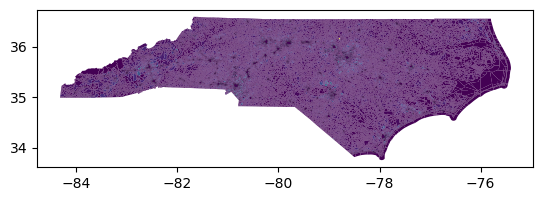

In [128]:
gdf_subset.plot("pop2016")

# Metamanering VTDs by packing

## Make Graph

In [160]:
gdf_subset['pos'] = gdf_subset.centroid


C:\Users\lnajt\AppData\Local\Temp\ipykernel_24728\522360522.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_subset['pos'] = gdf_subset.centroid


In [161]:
gdf_subset = gdf_subset.rename(columns = { "EL16G_GV_D_block" : "dem", "EL16G_GV_R_block" : "rep"})

In [164]:
gdf_subset['dem_prop'] = gdf_subset.dem / gdf_subset.TOTPOP_block
gdf_subset['rep_prop'] = gdf_subset.rep / gdf_subset.TOTPOP_block


### Saving the gdf

In [184]:
gpd.GeoDataFrame(gdf_subset.drop(columns = ["pos"]), geometry = "geometry",
                 crs= "ESRI:103500").to_file('./processed_data_outputs/blocks_df.geojson', driver='GeoJSON')  

### Making and  saving the graph

In [167]:
blocks_graph = Graph.from_geodataframe(gdf_subset, ignore_errors=True)#

C:\Users\lnajt\anaconda3\envs\gerry\lib\site-packages\gerrychain\graph\adjacency.py:23: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree = STRtree(geometries)
C:\Users\lnajt\anaconda3\envs\gerry\lib\site-packages\gerrychain\graph\graph.py:162: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()
C:\Users\lnajt\anaconda3\envs\gerry\lib\site-packages\gerrychain\graph\graph.py:272: UserWarning: NA values found in column dem_prop!
  warnings.warn("NA values found in column {}!".format(column))
C:\Users\lnajt\anaconda3\envs\gerry\lib\site-packages\gerrychain\graph\graph.py:272: UserWarning: NA values found in column rep_prop!
  warnings.warn("NA values found in column {}!".format(column))


In [169]:
blocks_graph.to_json('./processed_data_outputs/blocks_graph.json', include_geometries_as_geojson=True)

In [3]:
blocks_graph_in = Graph.from_json('./processed_data_outputs/blocks_graph.json')

## Aglomeration workflow

In [4]:
def agglomerate(graph, agg_field = "dem_prop", agg_field_threshold = .5,  pop_cap = 6000, 
                steps = 1000000):
    # go through map, agglomerate VTDs that have similar EL16G_GV_D_block proportions, until pop_cap is reached
    # also allow merging of zero pop blocks with no condition.
    for i in range(steps):
        #if i % 100000 == 0:
            #print(i)
        if i % 10000 == 0:
            edges = list(graph.edges())
        e = random.choice(edges)
        if graph.has_edge(e[0], e[1]):

            if  (graph.nodes[e[0]]['TOTPOP_block'] == 0 or
                 graph.nodes[e[1]]['TOTPOP_block'] == 0 or
                 (graph.nodes[e[0]][agg_field] >  agg_field_threshold and 
                graph.nodes[e[1]][agg_field] >  agg_field_threshold)):
                tot_pop = graph.nodes[e[0]]['TOTPOP_block'] + graph.nodes[e[1]]['TOTPOP_block']
                tot_dem = graph.nodes[e[0]]['dem']+ graph.nodes[e[1]]['dem']
                tot_rep = graph.nodes[e[0]]['rep'] + graph.nodes[e[1]]['rep']
                #print(tot_pop)
                if tot_pop < pop_cap:
                    graph.nodes[e[0]]['cluster'] = graph.nodes[e[0]]['cluster'] + graph.nodes[e[1]]['cluster'] 
                    nx.contracted_nodes(graph, e[0], e[1], copy = False, self_loops = False)
                    # according to documentation node named e[0] remains
                    #print(e)
                    graph.nodes[e[0]]['TOTPOP_block'] = tot_pop
                    graph.nodes[e[0]]['dem'] = tot_dem
                    graph.nodes[e[0]]['rep'] = tot_rep
                    if tot_pop !=0 :

                        graph.nodes[e[0]]['dem_prop'] = tot_dem / tot_pop
                        graph.nodes[e[0]]['rep_prop'] = tot_rep / tot_pop
                    else:
                        graph.nodes[e[0]]['dem_prop'] = np.nan
                        graph.nodes[e[0]]['rep_prop'] = np.nan

In [36]:
def create_candidate(blocks_graph,
                     target_num_vtds = 4000,
                    dem_threshold = .7, dem_pop_cap = 8000, dem_steps = 200000,
                    rep_threshold = 0, rep_pop_cap = 2000, rep_steps = 2000,
                     save = False,
                     print_progress = False
                    ):
    blocks_graph_test = blocks_graph_in.copy()
    if print_progress:
        print(f"Currently has {len(blocks_graph_test)} nodes")
    last = len(blocks_graph_test)
    for n in blocks_graph_test.nodes():
        blocks_graph_test.nodes[n]['cluster'] = [n]
    while len(blocks_graph_test) > target_num_vtds:
        agglomerate(graph = blocks_graph_test, agg_field = "dem_prop", 
                    agg_field_threshold = dem_threshold,  pop_cap = dem_pop_cap,  steps = dem_steps)
        agglomerate(graph = blocks_graph_test, agg_field = "rep_prop",  
                    agg_field_threshold = rep_threshold,  pop_cap = rep_pop_cap,  steps = rep_steps)
        if print_progress:
            print(f"Currently has {len(blocks_graph_test)} nodes")
        if len(blocks_graph_test) == last:
            # some more aggressive joining at this point
            agglomerate(graph = blocks_graph_test, agg_field = "rep_prop",  
                    agg_field_threshold = 0,  pop_cap = 3000,  steps = 2000000)
        last = len(blocks_graph_test)
    if print_progress:
        print("Finished. Stats:")    
        print(f"Has {len(blocks_graph_test)} VTDs")
        pops = []
        for node in blocks_graph_test.nodes():
            if blocks_graph_test.nodes[node]['dem'] > blocks_graph_test.nodes[node]['rep'] * 0:
                pops.append(blocks_graph_test.nodes[node]['TOTPOP_block'])
        pd.Series(pops).plot(kind = 'hist', bins = 30, title = "VTD pops")
        plt.show()
    name = str(datetime.now()).replace(" ", "").replace(":", "_")
    saved_name = f"candidate_blocks_graph{name}"
    if save == True:

        nx.write_gpickle(blocks_graph_test,f'./processed_data_outputs/{saved_name}.json')
    return blocks_graph_test, saved_name

In [8]:
#blocks_graph_test, saved_name = create_candidate(blocks_graph_in)

# Code to run gerrychain on the resulting graph

In [ ]:
def gerry(blocks_graph_test, gerrychain_steps = 10000, epsilon = .2):
    updaters = {'population': Tally('population'),
                        'cut_edges': cut_edges,
                        }
    num_districts = 13
    ideal_population= sum( blocks_graph_test.nodes[x]["TOTPOP_block"] for x in blocks_graph_test.nodes())/ num_districts

    for n in blocks_graph_test.nodes():
        blocks_graph_test.nodes[n]["population"] =  blocks_graph_test.nodes[n]["TOTPOP_block"]
    
        
    # accept imported
    initial_partition_assignment =gerrychain.tree.recursive_tree_part(blocks_graph_test, 
                                                            range(num_districts), 
                                                            ideal_population, "population", epsilon)
    
    for n in blocks_graph_test.nodes():
        blocks_graph_test.nodes[n]["district"] = initial_partition_assignment[n]
    
    initial_partition = Partition(blocks_graph_test, assignment='district',  updaters=updaters)
    
    
    popbound = within_percent_of_ideal_population(initial_partition, epsilon)
    tree_proposal = partial(recom, pop_col = 'population', pop_target=ideal_population, epsilon=epsilon,
                                node_repeats=1)


    exp_chain = MarkovChain(tree_proposal, Validator([popbound]), accept=accept.always_accept,
                            initial_state=initial_partition, total_steps=gerrychain_steps)
    seats_won_for_republicans = []
    seats_won_for_democrats = []
    
    for part in exp_chain:
        rep_seats_won = 0
        dem_seats_won = 0
        for j in range(num_districts):
            rep_votes = 0
            dem_votes = 0
            for n in blocks_graph_test.nodes():
                if part.assignment[n] == j:
                    rep_votes += blocks_graph_test.nodes[n]["rep"]
                    dem_votes += blocks_graph_test.nodes[n]["dem"]
            total_seats_dem = int(dem_votes > rep_votes)
            total_seats_rep = int(rep_votes > dem_votes)
            rep_seats_won += total_seats_rep
            dem_seats_won += total_seats_dem
        seats_won_for_republicans.append(rep_seats_won)
        seats_won_for_democrats.append(dem_seats_won)

    rep_avg = statistics.mean(seats_won_for_republicans)
    dem_avg = statistics.mean(seats_won_for_democrats)
    print("avg rep seats ", rep_avg)

    print("avg dem seats ", dem_avg)
    
    pd.Series(seats_won_for_republicans).plot(kind = 'hist', title = 'rep seats')
    plt.show()
    return dem_avg, rep_avg

avg rep seats  7.44
avg dem seats  5.56


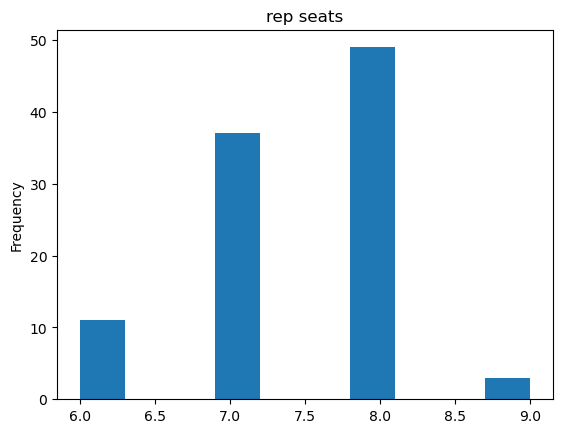

In [27]:
gerry(blocks_graph_test, gerrychain_steps = 100)

# Search flow

Currently has 288987 nodes
Currently has 225164 nodes
Currently has 188329 nodes
Currently has 163127 nodes
Currently has 142117 nodes
Currently has 122686 nodes
Currently has 104113 nodes
Currently has 86224 nodes
Currently has 69066 nodes
Currently has 53218 nodes
Currently has 39279 nodes
Currently has 27752 nodes
Currently has 19218 nodes
Currently has 13918 nodes
Currently has 11104 nodes
Currently has 9919 nodes
Currently has 9457 nodes
Currently has 9315 nodes
Currently has 9269 nodes
Currently has 9251 nodes
Currently has 9248 nodes
Currently has 9247 nodes
Currently has 9247 nodes
Finished. Stats:
Has 3125 VTDs


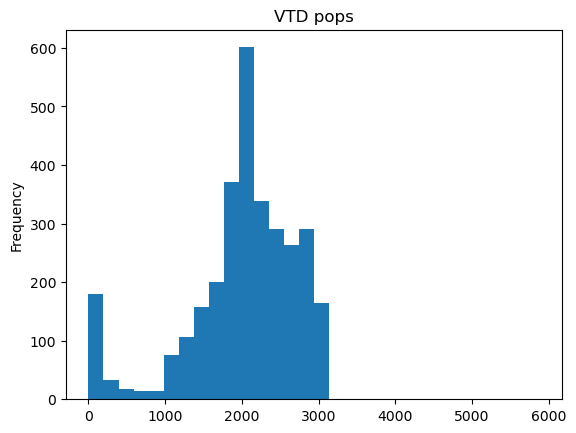

running gerrychain
avg rep seats  7.2102
avg dem seats  5.7898


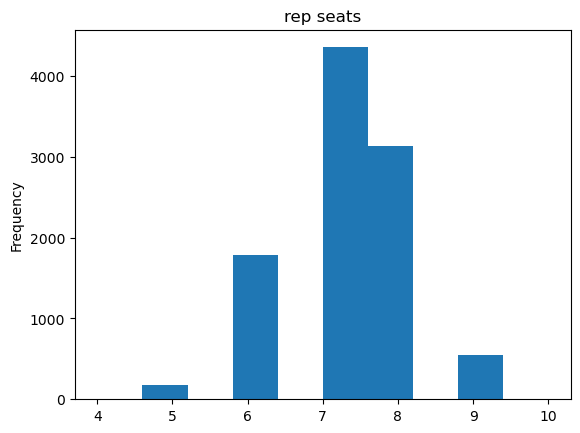

In [40]:
for dem_threshold in [.6,.7,.8]:
    blocks_graph_test, saved_name = create_candidate(blocks_graph_in,               
                        target_num_vtds = 4000,
                        dem_threshold = .6, dem_pop_cap = 8000, dem_steps = 200000,
                        rep_threshold = 0, rep_pop_cap = 2000, rep_steps = 20000,
                                                     save = False, print_progress = True)
    print('running gerrychain')
    dem_avg, rep_avg = gerry(blocks_graph_test, gerrychain_steps = 10000)
    if rep_avg > 9:
        print(f"success(?) with {saved_name} as {dem_avg}, {rep_avg}")
        print("writing to file")
        nx.write_gpickle(blocks_graph_test,f'./processed_data_outputs/{saved_name}.json')

Currently has 288987 nodes
Currently has 225175 nodes
Currently has 188318 nodes
Currently has 163161 nodes
Currently has 142055 nodes
Currently has 122617 nodes
Currently has 104062 nodes
Currently has 86131 nodes
Currently has 69015 nodes
Currently has 53105 nodes
Currently has 38936 nodes
Currently has 27535 nodes
Currently has 19110 nodes
Currently has 13789 nodes
Currently has 10994 nodes
Currently has 9922 nodes
Currently has 9481 nodes
Currently has 9357 nodes
Currently has 9304 nodes
Currently has 9289 nodes
Currently has 9282 nodes
Currently has 9279 nodes
Currently has 9279 nodes
Finished. Stats:
Has 3047 VTDs


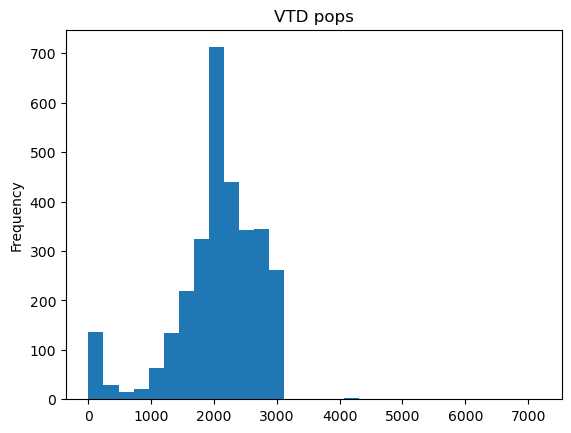

running gerrychain
avg rep seats  7.4207
avg dem seats  5.5793


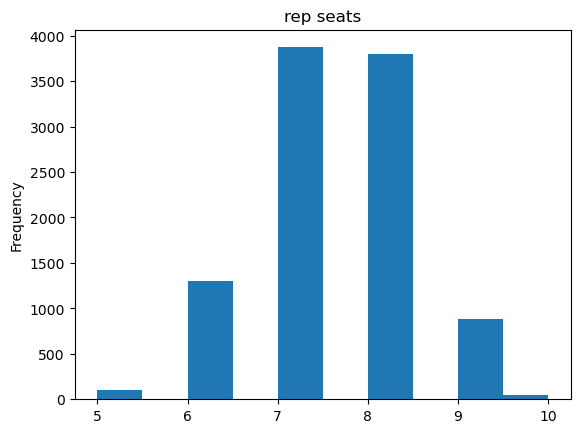

Currently has 288987 nodes
Currently has 225064 nodes
Currently has 188134 nodes
Currently has 162979 nodes
Currently has 141876 nodes
Currently has 122553 nodes
Currently has 103990 nodes
Currently has 86032 nodes
Currently has 68983 nodes
Currently has 53067 nodes
Currently has 38858 nodes
Currently has 27262 nodes
Currently has 18760 nodes
Currently has 13470 nodes
Currently has 10754 nodes
Currently has 9636 nodes
Currently has 9223 nodes
Currently has 9089 nodes
Currently has 9049 nodes
Currently has 9033 nodes
Currently has 9029 nodes
Currently has 9029 nodes
Finished. Stats:
Has 3044 VTDs


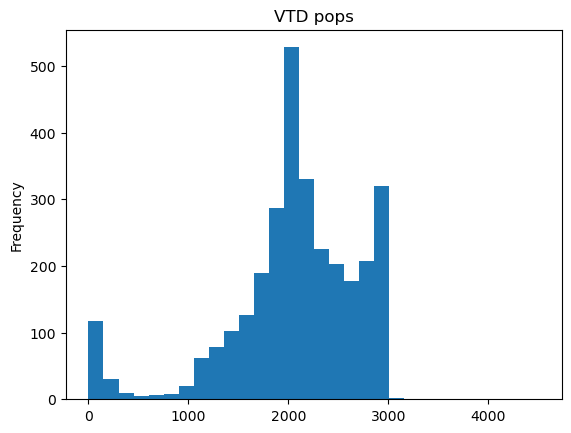

running gerrychain
avg rep seats  7.4358
avg dem seats  5.5642


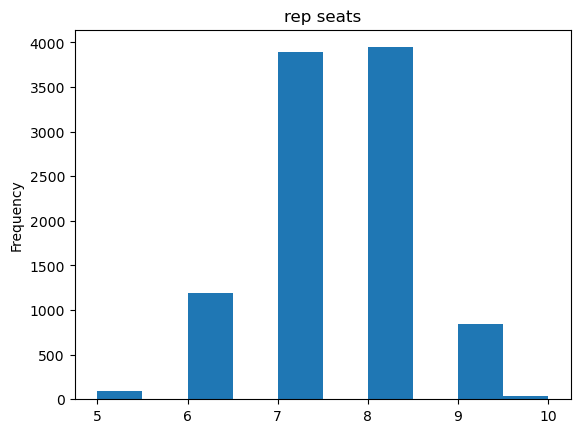

Currently has 288987 nodes
Currently has 224980 nodes
Currently has 188226 nodes
Currently has 163108 nodes
Currently has 142108 nodes
Currently has 122515 nodes
Currently has 103935 nodes
Currently has 85966 nodes
Currently has 68910 nodes
Currently has 52995 nodes
Currently has 38867 nodes
Currently has 27303 nodes
Currently has 18870 nodes
Currently has 13677 nodes
Currently has 10956 nodes
Currently has 9815 nodes
Currently has 9379 nodes
Currently has 9242 nodes
Currently has 9200 nodes
Currently has 9186 nodes
Currently has 9180 nodes
Currently has 9179 nodes
Currently has 9178 nodes
Currently has 9178 nodes
Finished. Stats:
Has 3056 VTDs


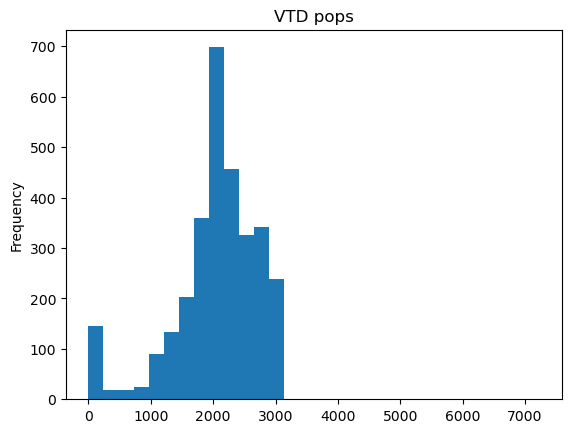

running gerrychain
avg rep seats  7.2481
avg dem seats  5.7519


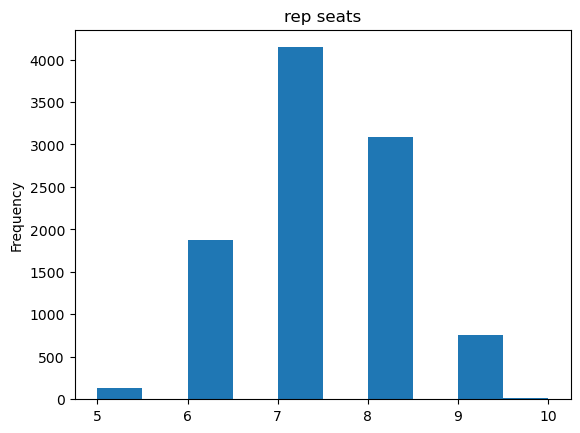

Currently has 288987 nodes
Currently has 225255 nodes
Currently has 188415 nodes
Currently has 163285 nodes
Currently has 142153 nodes
Currently has 122758 nodes
Currently has 104189 nodes
Currently has 86231 nodes
Currently has 69153 nodes
Currently has 53258 nodes
Currently has 39211 nodes
Currently has 27644 nodes
Currently has 19292 nodes
Currently has 14019 nodes
Currently has 11281 nodes
Currently has 10087 nodes
Currently has 9666 nodes
Currently has 9530 nodes
Currently has 9494 nodes
Currently has 9481 nodes
Currently has 9476 nodes
Currently has 9475 nodes
Currently has 9474 nodes
Currently has 9474 nodes
Finished. Stats:
Has 3055 VTDs


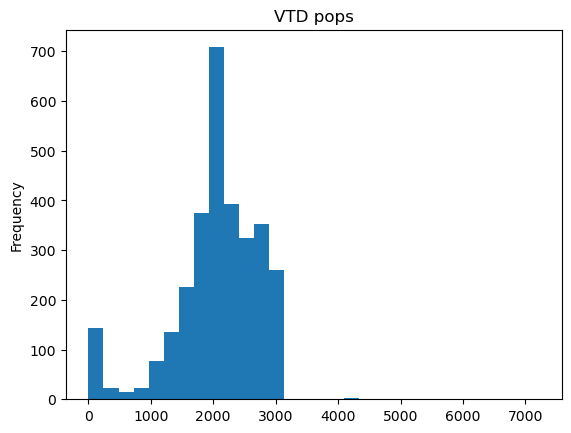

running gerrychain
avg rep seats  7.3384
avg dem seats  5.6616


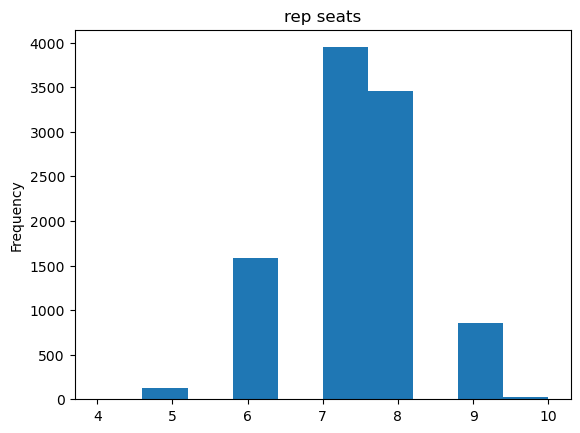

Currently has 288987 nodes
Currently has 225316 nodes
Currently has 188382 nodes
Currently has 163265 nodes
Currently has 142158 nodes
Currently has 122729 nodes
Currently has 104165 nodes
Currently has 86315 nodes
Currently has 69225 nodes
Currently has 53339 nodes
Currently has 39252 nodes
Currently has 27719 nodes
Currently has 19156 nodes
Currently has 13680 nodes
Currently has 10893 nodes
Currently has 9756 nodes
Currently has 9335 nodes
Currently has 9179 nodes
Currently has 9133 nodes
Currently has 9115 nodes
Currently has 9111 nodes
Currently has 9110 nodes
Currently has 9110 nodes
Finished. Stats:
Has 3061 VTDs


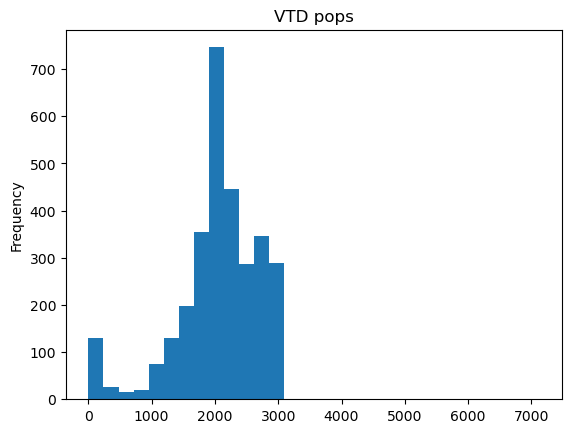

running gerrychain
avg rep seats  7.4116
avg dem seats  5.5884


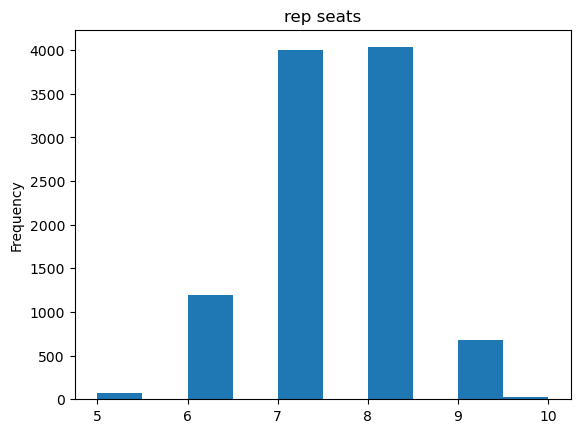

Currently has 288987 nodes
Currently has 225175 nodes
Currently has 188196 nodes
Currently has 162998 nodes
Currently has 141899 nodes
Currently has 122476 nodes
Currently has 104034 nodes
Currently has 86182 nodes
Currently has 69043 nodes
Currently has 53214 nodes
Currently has 39236 nodes
Currently has 27740 nodes
Currently has 19247 nodes
Currently has 13806 nodes
Currently has 10963 nodes
Currently has 9801 nodes
Currently has 9420 nodes
Currently has 9280 nodes
Currently has 9229 nodes
Currently has 9215 nodes
Currently has 9208 nodes
Currently has 9208 nodes
Finished. Stats:
Has 3050 VTDs


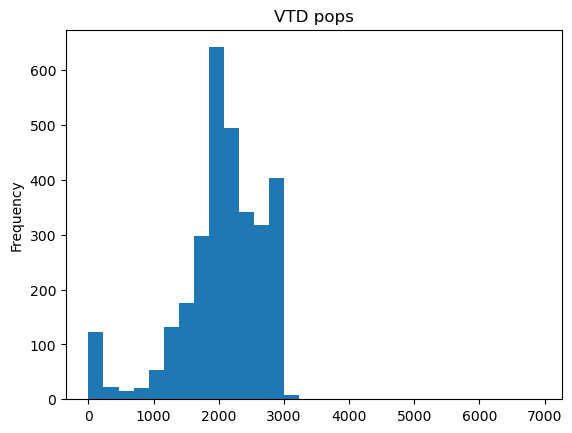

running gerrychain
avg rep seats  7.2979
avg dem seats  5.7021


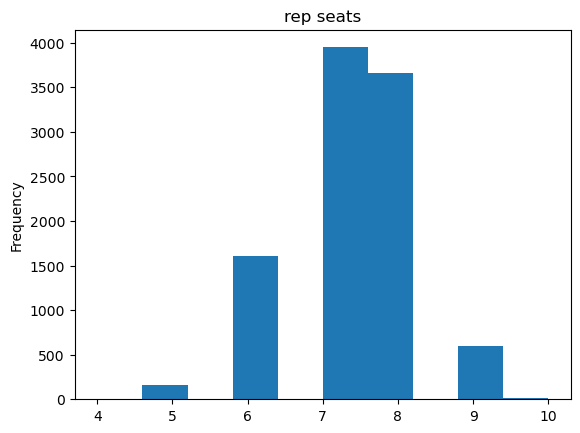

Currently has 288987 nodes
Currently has 225147 nodes
Currently has 188232 nodes
Currently has 163091 nodes
Currently has 142010 nodes
Currently has 122577 nodes
Currently has 103976 nodes
Currently has 86099 nodes
Currently has 69000 nodes
Currently has 53023 nodes
Currently has 38947 nodes
Currently has 27439 nodes
Currently has 19179 nodes
Currently has 13889 nodes
Currently has 11102 nodes
Currently has 9909 nodes
Currently has 9508 nodes
Currently has 9381 nodes
Currently has 9344 nodes
Currently has 9333 nodes
Currently has 9329 nodes
Currently has 9326 nodes
Currently has 9326 nodes
Finished. Stats:
Has 3055 VTDs


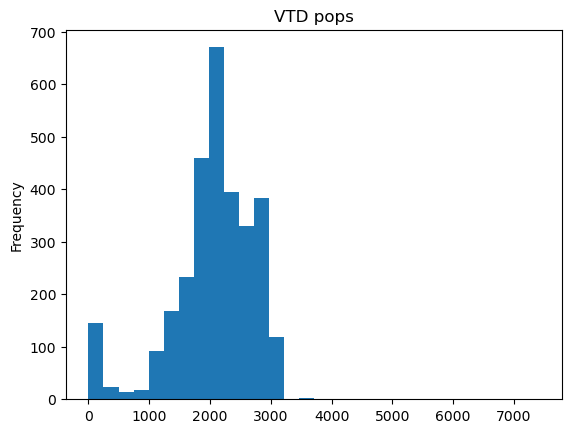

running gerrychain
avg rep seats  7.4434
avg dem seats  5.5566


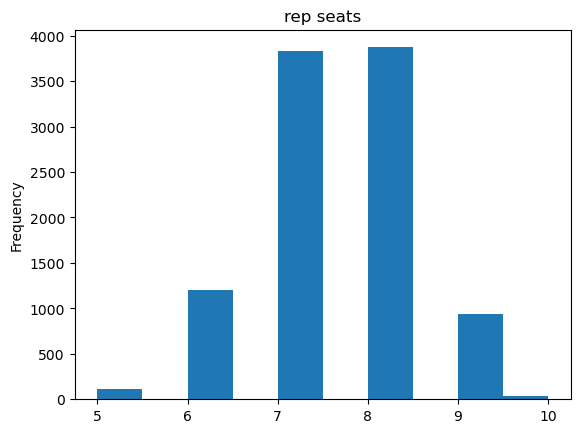

Currently has 288987 nodes
Currently has 225018 nodes
Currently has 188111 nodes
Currently has 163014 nodes
Currently has 141931 nodes
Currently has 122506 nodes
Currently has 103902 nodes
Currently has 85930 nodes
Currently has 68837 nodes
Currently has 52866 nodes
Currently has 38761 nodes
Currently has 27187 nodes
Currently has 18768 nodes
Currently has 13491 nodes
Currently has 10845 nodes
Currently has 9730 nodes
Currently has 9358 nodes
Currently has 9224 nodes
Currently has 9177 nodes
Currently has 9162 nodes
Currently has 9157 nodes
Currently has 9156 nodes
Currently has 9155 nodes
Currently has 9155 nodes
Finished. Stats:
Has 3071 VTDs


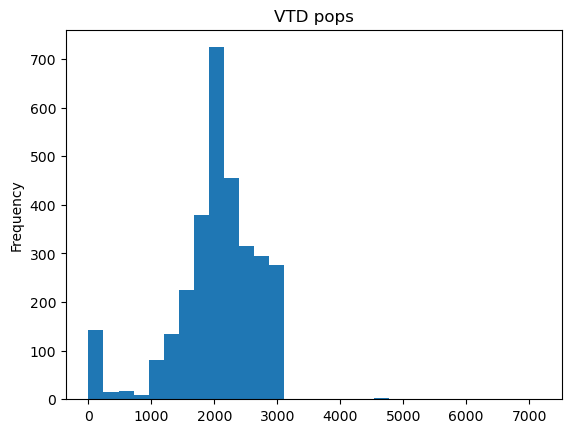

running gerrychain
avg rep seats  7.4189
avg dem seats  5.5811


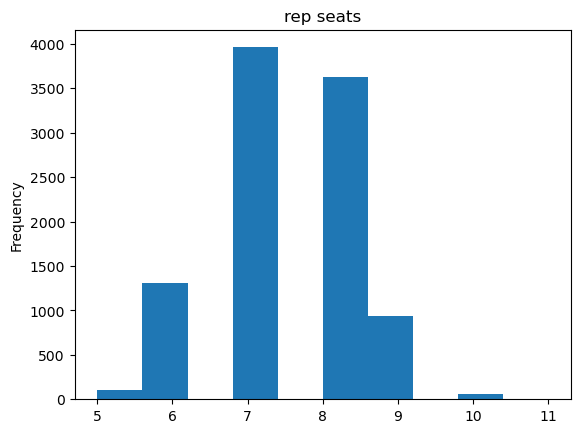

Currently has 288987 nodes
Currently has 225078 nodes
Currently has 188102 nodes
Currently has 163012 nodes
Currently has 141960 nodes
Currently has 122512 nodes
Currently has 103997 nodes
Currently has 86076 nodes
Currently has 69026 nodes
Currently has 52976 nodes
Currently has 38934 nodes
Currently has 27325 nodes
Currently has 18887 nodes
Currently has 13617 nodes
Currently has 10924 nodes
Currently has 9764 nodes
Currently has 9400 nodes
Currently has 9278 nodes
Currently has 9237 nodes
Currently has 9215 nodes
Currently has 9212 nodes
Currently has 9210 nodes
Currently has 9210 nodes
Finished. Stats:
Has 3037 VTDs


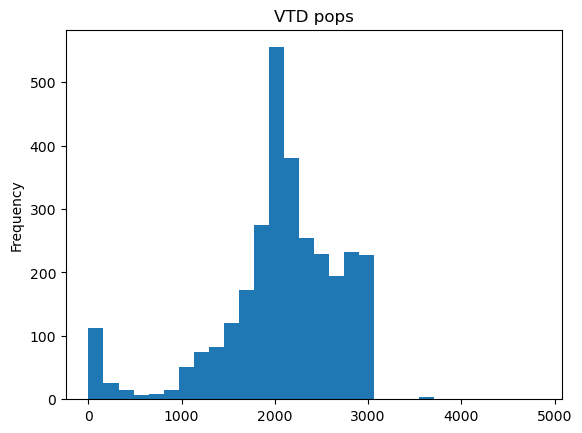

running gerrychain


KeyboardInterrupt: 

In [42]:
rep_avgs = []
for i in range(100):
    for dem_threshold in [.6,.7,.8]:
        blocks_graph_test, saved_name = create_candidate(blocks_graph_in,               
                            target_num_vtds = 4000,
                            dem_threshold = .6, dem_pop_cap = 8000, dem_steps = 200000,
                            rep_threshold = 0, rep_pop_cap = 2000, rep_steps = 20000,
                                                         save = False, print_progress = True)
        print('running gerrychain')
        dem_avg, rep_avg = gerry(blocks_graph_test, gerrychain_steps = 10000)
        rep_avgs.append(rep_avg)
        if rep_avg > 9:
            print(f"success(?) with {saved_name} as {dem_avg}, {rep_avg}")
            print("writing to file")
            nx.write_gpickle(blocks_graph_test,f'./processed_data_outputs/{saved_name}.json')

Actually makes sense that if agglomerate well end up with large nodes.

In [43]:
rep_avgs

[7.4207, 7.4358, 7.2481, 7.3384, 7.4116, 7.2979, 7.4434, 7.4189]

In [60]:
totpop = sum( blocks_graph_test.nodes[x]["population"] for x in blocks_graph_test.nodes())
rep_tot = sum( blocks_graph_test.nodes[x]["rep"] for x in blocks_graph_test.nodes())
rep_tot/ totpop

0.2399412824682898

0.2399412824682898

In [59]:
vtd = gpd.read_file("./data/NC_VTD.shp").to_crs("EPSG:4269")

In [65]:
totpop =  vtd["TOTPOP"].sum()
rep_tot = vtd["EL16G_GV_D"].sum()
rep_tot/ totpop

0.24124430823273452

In [66]:
partition

NameError: name 'partition' is not defined